# 2D Post-stack inversion with different forms of ADMM

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import filtfilt
from scipy.linalg import solve
from scipy.sparse.linalg import lsqr
from matplotlib.colors import LinearSegmentedColormap

from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.utils.wavelets import *
from pylops.avo.poststack import *
from pylops.optimization.sparsity import *
from pylops.basicoperators import VStack as VStacklop

from pyproximal.proximal import *
from pyproximal import ProxOperator
from pyproximal.optimization.primal import *

In [2]:
def PSNR(x, xinv):
    return 10 * np.log10(len(xinv) * np.max(xinv)**2 / np.linalg.norm(x-xinv)**2)

## 2D Post-stack inversion

We consider the following problem

$$
\mathbf{x} = arg min_\mathbf{x} f(x) + g(Dx)
$$

where $f=\frac{\sigma}{2} ||\mathbf{W}\mathbf{D}\mathbf{x} - \mathbf{y} ||_2^2$ and  $g(Dx)=||\mathbf{D} \mathbf{x}||_1$ or $g(Dx)=||\mathbf{D} \mathbf{x}||_{2,1}$.

We can either solve this with:

- Linearized ADMM
- ADMM with the following constraint $\mathbf{D}\mathbf{x}-\mathbf{z}=0$, so $\mathbf{A}=\mathbf{D}$, $\mathbf{B}=-\mathbf{I}$, and $c=0$

## Model creation

In [3]:
nt0, nx = 301, 251
dt0 = 0.004
t0 = np.arange(nt0)*dt0
dx = 4
x = np.arange(nx)*dx

ai = 1800 * np.ones(nt0)
ai[51:71] = 1900
ai[71:121] = 2100
ai[121:151] = 1600
ai[151:251] = 2000
ai[251:] = 2200
ai1 = np.outer(ai, np.ones(nx))
ai2d = np.roll(ai1, 32, axis=0)
ai2d[:32] = 1800

# fault
tf = 0.3
kf = 5e-4
fault = x * kf + tf
mask = np.zeros_like(ai1, dtype=int)
for ix in range(nx):
    ai2d[int(fault[ix]/dt0):, ix] = ai1[int(fault[ix]/dt0):, ix]
ai2d *= 2000
m = np.log(ai2d)

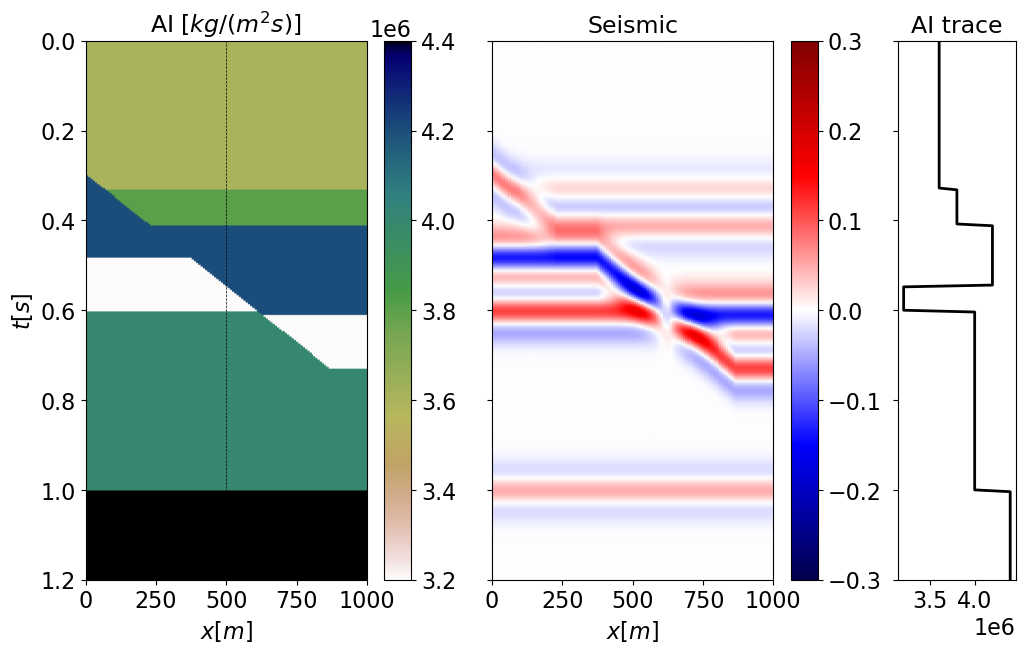

In [4]:
# smooth model
nsmooth = 20
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, m, axis=0)

# wavelet
ntwav = 61
wav, twav, wavc = ricker(t0[:ntwav//2+1], 8)

# operator
Lop = PoststackLinearModelling(wav / 2, nt0=nt0, spatdims=nx)

# data
d = Lop * m.ravel()
d = d.reshape(nt0, nx)

# random noise
#sigman = 2e-2
#n = np.random.normal(0, sigman, d.shape)

# colored noise
sigman = 0 # 6e-2
n = filtfilt(np.ones(10)/10, 1,
             filtfilt(np.ones(5)/5, 1, np.random.normal(0, sigman, (nt0, nx)).T, method='gust').T,
             method='gust')
dn = d + n

fig, axs = plt.subplots(1, 3, sharey=True, gridspec_kw={'width_ratios': [3, 3, 1]}, figsize=(12, 7))
im = axs[0].imshow(np.exp(m), vmin=3.2e6, vmax=4.4e6,
                   cmap='gist_earth_r', extent=(x[0], x[-1], t0[-1], t0[0]))
axs[0].axvline(x[nx//2], c='k', ls='--', lw=0.5)
plt.colorbar(im, ax=axs[0])
axs[0].axis('tight')
axs[0].set_ylabel(r'$t [s]$')
axs[0].set_xlabel(r'$x [m]$')
axs[0].set_title(r'AI $[kg/(m^2s)]$', fontsize=17)
im = axs[1].imshow(dn, cmap='seismic', vmin=-0.3, vmax=0.3, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1].set_xlabel(r'$x [m]$')
axs[1].set_title('Seismic', fontsize=17)
axs[1].axis('tight')
plt.colorbar(im, ax=axs[1])
axs[2].plot(np.exp(m[:, nx//2]), t0, 'k', lw=2)
axs[2].axis('tight')
axs[2].set_title('AI trace', fontsize=17);

In [5]:
# L-ADMM (Blockiness-promoting inversion with isotropic TV)
sigma=0.01
l1 = L21(ndim=2, sigma=sigma)
l2 = L2(Op=Lop, b=dn.ravel(), x0=mback.ravel(), niter=20, warm=True)
Dop = Gradient(dims=(nt0, nx), edge=True, dtype=Lop.dtype, kind='forward')

L = 8. #np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = 0.99 * tau / L # optimal mu<=tau/maxeig(Dop^H Dop)

mladmm = LinearizedADMM(l2, l1, Dop, tau=tau, mu=mu, x0=mback.ravel(), niter=100, show=True)[0]
dinv = Lop*mladmm

mladmm = mladmm.reshape(nt0, nx)
dinv = dinv.reshape(nt0, nx)

Linearized-ADMM
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.gradient.Gradient'>
tau = 1.000000e+00	mu = 1.237500e-01	niter = 100

   Itn       x[0]          f           g       J = f + g
     1   1.50964e+01   1.788e+01   1.572e+00   1.945e+01
     2   1.50964e+01   1.310e+01   1.577e+00   1.467e+01
     3   1.50964e+01   9.712e+00   1.616e+00   1.133e+01
     4   1.50964e+01   7.328e+00   1.685e+00   9.014e+00
     5   1.50964e+01   5.635e+00   1.781e+00   7.416e+00
     6   1.50964e+01   4.421e+00   1.873e+00   6.294e+00
     7   1.50965e+01   3.539e+00   1.954e+00   5.492e+00
     8   1.50965e+01   2.889e+00   2.025e+00   4.914e+00
     9   1.50965e+01   2.400e+00   2.086e+00   4.486e+00
    10   1.50966e+01   2.027e+00   2.135e+00   4.163e+00
    11   1.50966e+01   1.739e+00   2.175e+00   3.914e+00
 

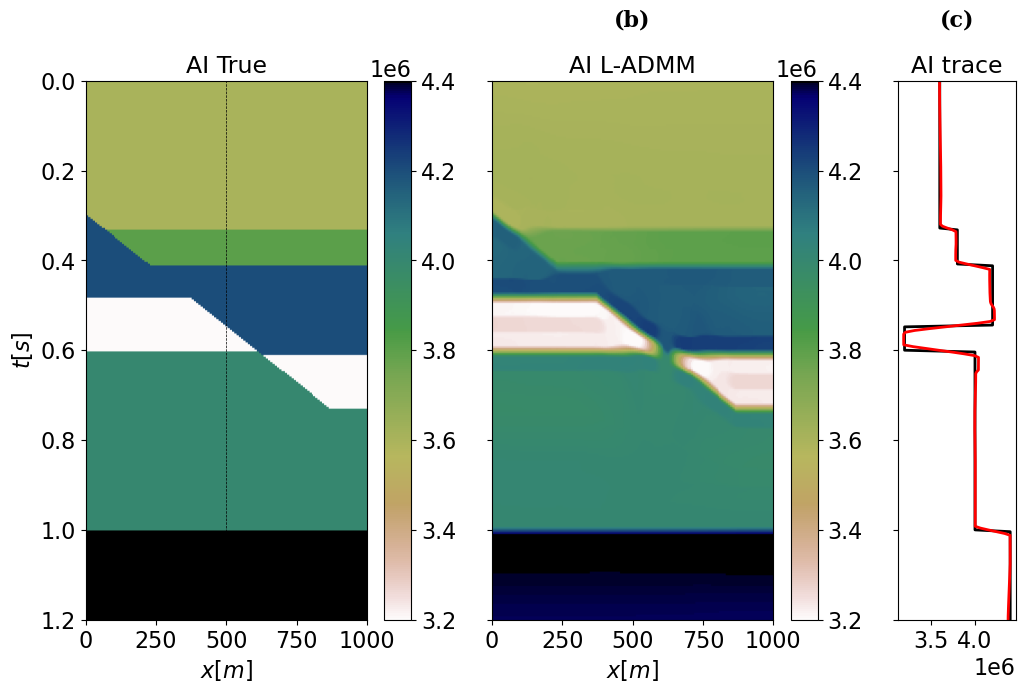

In [6]:
fig, axs = plt.subplots(1, 3, sharey=True, gridspec_kw={'width_ratios': [3, 3, 1]}, figsize=(12, 7))
im = axs[0].imshow(np.exp(m), vmin=3.2e6, vmax=4.4e6,
                   cmap='gist_earth_r', extent=(x[0], x[-1], t0[-1], t0[0]))
axs[0].axvline(x[nx//2], c='k', ls='--', lw=0.5)
plt.colorbar(im, ax=axs[0])
axs[0].axis('tight')
axs[0].set_ylabel(r'$t [s]$')
axs[0].set_xlabel(r'$x [m]$')
axs[0].set_title(r'AI True', fontsize=17)
im = axs[1].imshow(np.exp(mladmm), vmin=3.2e6, vmax=4.4e6,
                   cmap='gist_earth_r', extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1].text(0.5, 1.1, '(b)', ha='center', fontsize=16, fontweight='bold', 
            family='serif', transform=axs[1].transAxes)
axs[1].set_xlabel(r'$x [m]$')
axs[1].set_title('AI L-ADMM', fontsize=17)
axs[1].axis('tight')
plt.colorbar(im, ax=axs[1])
axs[2].plot(np.exp(m[:, nx//2]), t0, 'k', lw=2)
axs[2].plot(np.exp(mladmm[:, nx//2]), t0, 'r', lw=2)
axs[2].text(0.5, 1.1, '(c)', ha='center', fontsize=16, fontweight='bold', 
            family='serif', transform=axs[2].transAxes)
axs[2].axis('tight')
axs[2].set_title('AI trace', fontsize=17);

In [7]:
# ADMML2 (Blockiness-promoting inversion with isotropic TV)
sigma=0.01
l1 = L21(ndim=2, sigma=sigma)
Dop = Gradient(dims=(nt0, nx), edge=True, dtype=Lop.dtype, kind='forward')

L = 8. #np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 0.99 / L

madmm = ADMML2(l1, Lop, dn.ravel(), Dop, x0=mback.ravel(), tau=tau, 
              niter=100, show=True, **dict(iter_lim=20))[0]
dinv = Lop*madmm

madmm = madmm.reshape(nt0, nx)
dinv = dinv.reshape(nt0, nx)

ADMM
---------------------------------------------------------
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
tau = 1.237500e-01	niter = 100

   Itn       x[0]          f           g       J = f + g
     1   1.50992e+01   3.577e+00   2.099e+00   5.677e+00
     2   1.50932e+01   1.176e+00   2.226e+00   3.402e+00
     3   1.50909e+01   5.370e-01   2.337e+00   2.874e+00
     4   1.51019e+01   3.728e-01   2.323e+00   2.696e+00
     5   1.51023e+01   2.934e-01   2.280e+00   2.573e+00
     6   1.51108e+01   2.510e-01   2.254e+00   2.505e+00
     7   1.51063e+01   2.219e-01   2.225e+00   2.447e+00
     8   1.51099e+01   2.007e-01   2.211e+00   2.411e+00
     9   1.51053e+01   1.860e-01   2.193e+00   2.379e+00
    10   1.51054e+01   1.747e-01   2.171e+00   2.346e+00
    11   1.51016e+01   1.659e-01   2.153e+00   2.319e+00
    21   1.50973e+01   1.243e-01   2.037e+00   2.162e+00
    31   1.51026e+01   1.027e-01   1.972e+00   2.074e+00
    41   1.51016e+01   9.229e-02   1.936e+00  

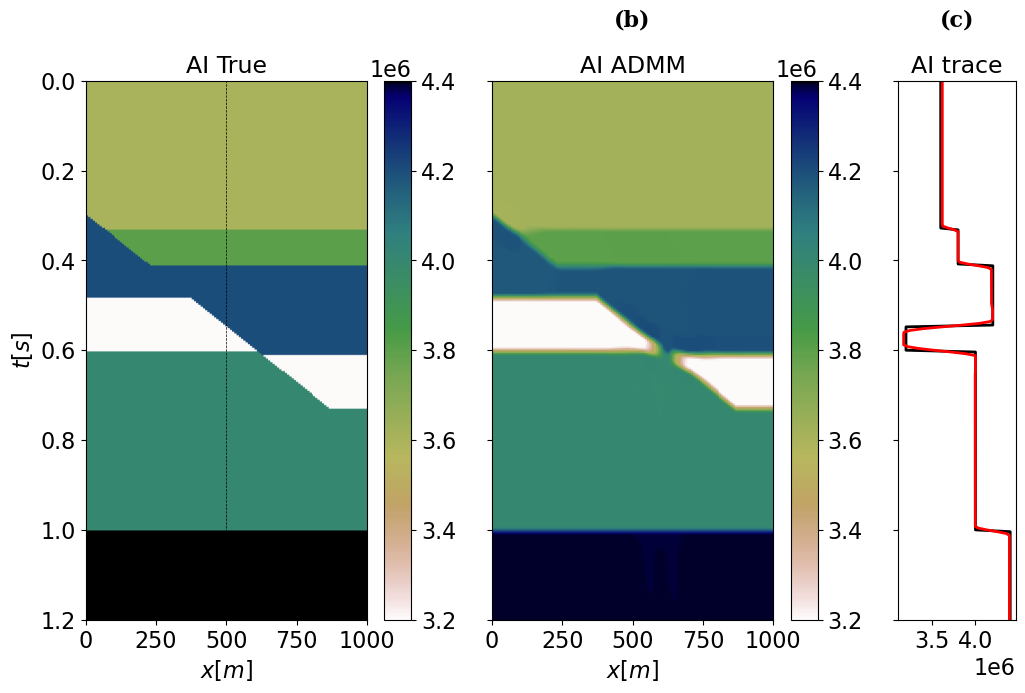

In [8]:
fig, axs = plt.subplots(1, 3, sharey=True, gridspec_kw={'width_ratios': [3, 3, 1]}, figsize=(12, 7))
im = axs[0].imshow(np.exp(m), vmin=3.2e6, vmax=4.4e6,
                   cmap='gist_earth_r', extent=(x[0], x[-1], t0[-1], t0[0]))
axs[0].axvline(x[nx//2], c='k', ls='--', lw=0.5)
plt.colorbar(im, ax=axs[0])
axs[0].axis('tight')
axs[0].set_ylabel(r'$t [s]$')
axs[0].set_xlabel(r'$x [m]$')
axs[0].set_title(r'AI True', fontsize=17)
im = axs[1].imshow(np.exp(madmm), vmin=3.2e6, vmax=4.4e6,
                   cmap='gist_earth_r', extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1].text(0.5, 1.1, '(b)', ha='center', fontsize=16, fontweight='bold', 
            family='serif', transform=axs[1].transAxes)
axs[1].set_xlabel(r'$x [m]$')
axs[1].set_title('AI ADMM', fontsize=17)
axs[1].axis('tight')
plt.colorbar(im, ax=axs[1])
axs[2].plot(np.exp(m[:, nx//2]), t0, 'k', lw=2)
axs[2].plot(np.exp(madmm[:, nx//2]), t0, 'r', lw=2)
axs[2].text(0.5, 1.1, '(c)', ha='center', fontsize=16, fontweight='bold', 
            family='serif', transform=axs[2].transAxes)
axs[2].axis('tight')
axs[2].set_title('AI trace', fontsize=17);

In [9]:
# ADMM (Blockiness-promoting inversion with isotropic TV)
sigma=1e3
tv = TV(dims=(nt0, nx), sigma=sigma, rtol=1e-2)
l2 = L2(Op=Lop, b=dn.ravel(), x0=mback.ravel(), niter=20, warm=True, sigma=1e3)

L = np.real((Lop.H*Lop).eigs(neigs=1, which='LM')[0])
print(L)
tau = 0.99 / L

madmm1 = ADMM(l2, tv, x0=mback.ravel(), tau=tau, niter=100, show=True)[0]
dinv = Lop*madmm1

madmm1 = madmm1.reshape(nt0, nx)
dinv = dinv.reshape(nt0, nx)

2.064480339525495
ADMM
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.TV.TV'>
tau = 4.795396e-01	niter = 100

   Itn       x[0]          f           g       J = f + g
     1   1.50998e+01   1.315e+02   3.069e+05   3.070e+05
     2   1.50903e+01   5.540e+01   3.100e+05   3.100e+05
     3   1.50892e+01   3.561e+01   3.062e+05   3.063e+05
     4   1.50879e+01   2.732e+01   3.096e+05   3.096e+05
     5   1.50881e+01   2.250e+01   3.098e+05   3.099e+05
     6   1.50881e+01   1.941e+01   3.113e+05   3.113e+05
     7   1.50881e+01   1.728e+01   3.112e+05   3.112e+05
     8   1.50883e+01   1.564e+01   3.117e+05   3.117e+05
     9   1.50883e+01   1.440e+01   3.113e+05   3.113e+05
    10   1.50884e+01   1.334e+01   3.116e+05   3.116e+05
    11   1.50884e+01   1.250e+01   3.112e+05   3.112e+05
    21   1.50888e+01   8.114e+00   3.115e+05   3.115e+05
    31   1.50892e+01   6.593

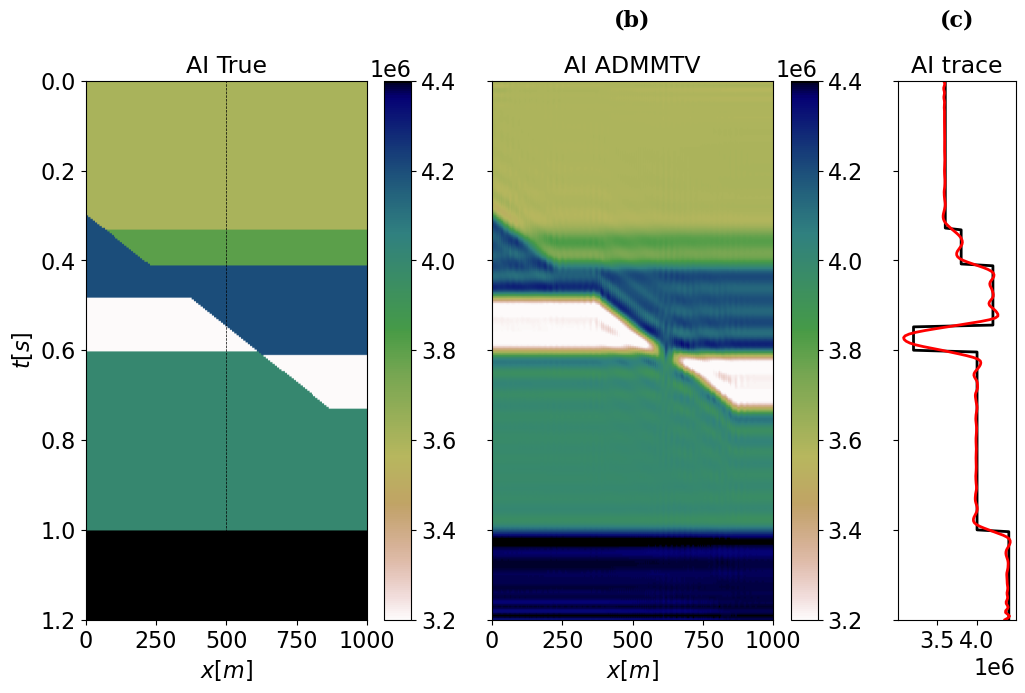

In [10]:
fig, axs = plt.subplots(1, 3, sharey=True, gridspec_kw={'width_ratios': [3, 3, 1]}, figsize=(12, 7))
im = axs[0].imshow(np.exp(m), vmin=3.2e6, vmax=4.4e6,
                   cmap='gist_earth_r', extent=(x[0], x[-1], t0[-1], t0[0]))
axs[0].axvline(x[nx//2], c='k', ls='--', lw=0.5)
plt.colorbar(im, ax=axs[0])
axs[0].axis('tight')
axs[0].set_ylabel(r'$t [s]$')
axs[0].set_xlabel(r'$x [m]$')
axs[0].set_title(r'AI True', fontsize=17)
im = axs[1].imshow(np.exp(madmm1), vmin=3.2e6, vmax=4.4e6,
                   cmap='gist_earth_r', extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1].text(0.5, 1.1, '(b)', ha='center', fontsize=16, fontweight='bold', 
            family='serif', transform=axs[1].transAxes)
axs[1].set_xlabel(r'$x [m]$')
axs[1].set_title('AI ADMMTV', fontsize=17)
axs[1].axis('tight')
plt.colorbar(im, ax=axs[1])
axs[2].plot(np.exp(m[:, nx//2]), t0, 'k', lw=2)
axs[2].plot(np.exp(madmm1[:, nx//2]), t0, 'r', lw=2)
axs[2].text(0.5, 1.1, '(c)', ha='center', fontsize=16, fontweight='bold', 
            family='serif', transform=axs[2].transAxes)
axs[2].axis('tight')
axs[2].set_title('AI trace', fontsize=17);

In [11]:
PSNR(m, mladmm), PSNR(m, madmm), PSNR(m, madmm1)

(np.float64(35.75027198069278),
 np.float64(37.23315467488403),
 np.float64(34.834239629197654))